In [1]:
# Initial imports and environment setting.

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the data. This spreadsheet is (almost) direct from SurveyMonkey,
# though IP addresses and access dates were scrubbed to anonymize.
df = pd.read_csv('aperture_survey_responses.tsv', sep='\t')

In [3]:
# SurveyMonkey provides an odd nesting of responses when exporting results.
# We'd like to convert this structure to a pandas MultiIndex data frame.
# First, let's find question indices -- adapted from https://stackoverflow.com/a/49584888

indices = [i for i, c in enumerate(df.columns) if not c.startswith('Unnamed')]
slices = [slice(i, j) for i, j in zip(indices, indices[1:] + [None])]
repeats = [len(range(*slice.indices(len(df.columns)))) for slice in slices]

In [4]:
# Now let's grab all of the questions and each of the options provided as possible responses.
questions = [c for c in df.columns if not c.startswith('Unnamed')]
options = df.iloc[:1].values[0].tolist()

# We can pair each possible response with its associated question...
matched_questions = []
for index, question in enumerate(questions):
    matched_questions += [question] * repeats[index]

# ...and create a new dataframe named 'responses' that correctly pairs questions and responses.
index = pd.MultiIndex.from_arrays([matched_questions, options],
                                  names=('question', 'options'))
data = df.iloc[2:].values
responses = pd.DataFrame(data=data, columns=index)

In [5]:
# Optional data cleaning -- remove 'Other' responses for easier plotting.
others = ['Other (please specify)', 'Other',
          '* If you selected other please specify',
          '*If you selected other, please specify']
for o in others:
    responses.drop(o, axis=1, level=1, inplace=True)

In [6]:
# First question of interest --
responses['Should OHBM have an official publishing platform?',
          'Response'].value_counts(normalize=True)  # the normalize keyword converts to percentages

Yes    0.865591
No     0.134409
Name: (Should OHBM have an official publishing platform?, Response), dtype: float64

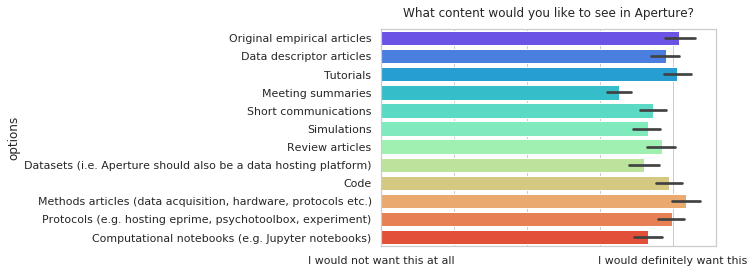

In [7]:
# Next, we'd like to look at want content respondents wanted published in Aperture
# For ease of intepretation, I've reverse-coded the values for these and the
# subsequent two plots.

content = responses['What content would you like to see in Aperture? \
(1 = would definitely want this, 5 = I would not want this at all)'].apply(pd.to_numeric, errors='raise')
content = content.applymap(lambda x: 6 - x)  # Here's where we reverse the scoring

ax = sns.barplot(data=content, orient='h', palette='rainbow')
plt.title('What content would you like to see in Aperture?', pad=12)
plt.xticks(np.arange(0, 5), ('I would not want this at all', '', '', '', 'I would definitely want this'));

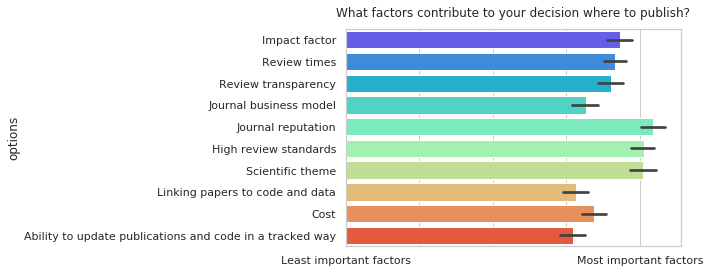

In [8]:
# Next, we'd like to know what factors generally influence where respondents publish.

decision = responses['What factors contribute to your decision where to publish? \
(1 = most important, 5 = least important)'].apply(pd.to_numeric, errors='coerce')
decision = decision.applymap(lambda x: 6 - x)  # Here's where we reverse the scoring

ax = sns.barplot(data=decision, orient='h', palette='rainbow')
plt.title('What factors contribute to your decision where to publish?', pad=12)
plt.xticks(np.arange(0, 5), ('Least important factors', '', '', '', 'Most important factors'));

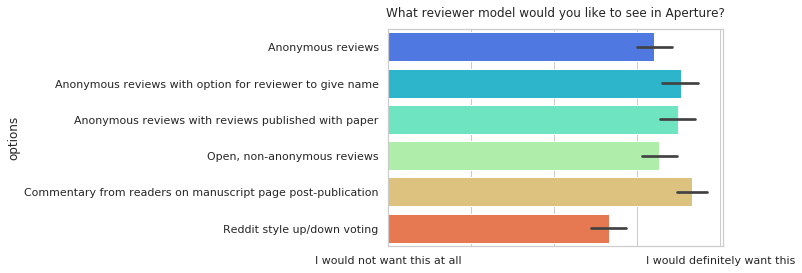

In [9]:
# Finally, we'd like to know what reviewing model respondents would like to see available in Aperture.
# For a summary of the different models, see:
# https://authorservices.wiley.com/Reviewers/journal-reviewers/what-is-peer-review/types-of-peer-review.html

model = responses['What reviewer model would you like to see in Aperture? \
(1 = I would definitely want this , 5 = I would not want this at all)'].apply(pd.to_numeric, errors='raise')
model = model.applymap(lambda x: 6 - x)  # Here's where we reverse the scoring

ax = sns.barplot(data=model, orient='h', palette='rainbow')
plt.title('What reviewer model would you like to see in Aperture?', pad=12)
plt.xticks(np.arange(0, 5), ('I would not want this at all', '', '', '', 'I would definitely want this'));

On average, respondents were willing to pay $50 per submission to Aperture.
They also indicated they would pay an additional $750 to publish in Aperture.


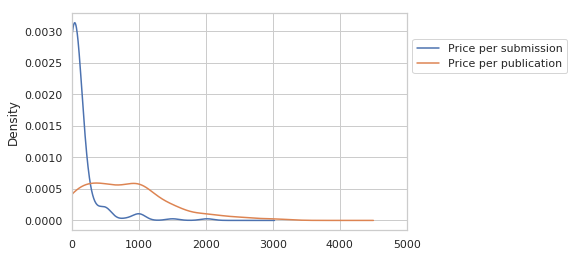

In [15]:
# What are respondents willing to pay to sustain Aperture ?
price_per_sub = pd.to_numeric(responses['Per submission:',
                                        'Open-Ended Response'])
price_per_pub = pd.to_numeric(responses['Per publication:',
                                        'Open-Ended Response'])

# Let's look at the distributions
pd.concat([price_per_sub, price_per_pub], axis=1).plot.kde(xlim=[0, 5000]);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.8),
           labels=['Price per submission', 'Price per publication']);

# Then we'll print the central tendency for each of these two responses
# Using median since the distributions are skewed

print('On average, respondents were willing to pay ${:.0f} \
per submission to Aperture.'.format(price_per_sub.median()))
print('They also indicated they would pay an additional ${:.0f} \
to publish in Aperture.'.format(price_per_pub.median()))
